In [1]:
#%matplotlib widget
%matplotlib notebook
%load_ext autoreload
%autoreload 2


import matplotlib.pyplot as plt
import matplotlib.gridspec as GridSpec
import numpy as np
import os

# from tqdm import tqdm, tqdm_notebook
import math


from scipy.optimize import curve_fit


# from  scipy.special import digamma as ψ
# from mpmath import besseli as Iν
# from scipy.constants import hbar, pi, h, e, k

# kB = k
# γ = 0.57721566
# RQ = h/4/e**2
# Φ0 = h/2/e

from JJformulas import *

import qcodes as qc
from qcodes.dataset.database import initialise_database
from qcodes.dataset.plotting import plot_by_id, get_data_by_id
from qcodes.dataset.data_set import load_by_run_spec, DataSet

from scipy import integrate
from scipy.special import gamma

import matplotlib.patches as patches
from mpl_toolkits.mplot3d import Axes3D

c:\users\tom\documents\github\qcodes\qcodes\dataset\database.py:13: UserWarning: The module `qcodes.dataset.database` is deprecated.
Public features are available at the import of `qcodes`.
Private features are available in `qcodes.dataset.sqlite.*` modules.
  warnings.warn('The module `qcodes.dataset.database` is deprecated.\n'


# Notes on theory of JJ

The intention of this note is to summarize and organize the knowledge on the physics of single JJ, namely TA and Q phase diffusion, environment impedance influence, Bloch oscillations, etc  

## 1. RS(C)J-model

The simplest model considers current-biasing circuit consisted of Josephson element, Resistor and capasitor.

$I_s = I_c \sin \phi$

$\dot{\phi} = \frac{2 e}{ \hbar} V $

$ I_0 = \frac{\hbar C}{2e} \ddot{ \phi }  + \frac{\hbar}{ 2eR} \dot \phi + I_c \sin \phi $


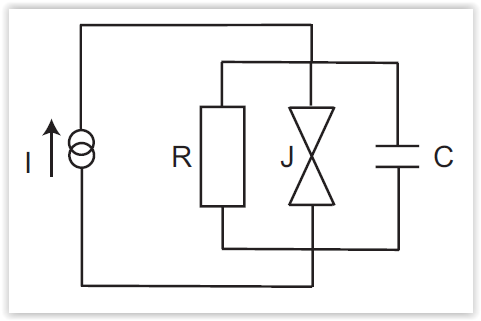
[Kopnin lecture]

$\omega_p = \sqrt{2eI_c/\hbar C} = \sqrt{8 E_J E_C}$ - plasma frequency

$Q = \omega_p R C$ - quality factor

### 1a) $C \rightarrow \infty $
Equvalent to underdamped regime ( $ 1/ \omega_p C \ll R $, $Q \gg 1$ ). Capacitence completely shunts josephson generation 

$$I_0 < I_c \Rightarrow I_s = I_0, I_R = 0, I_C = 0$$

$$I_0 > I_c \Rightarrow \overline{I_s + I_C} = 0, I_R = I_0$$

### 2a) $ C = 0$

Equvalent to overdamped regime ( $ 1/ \omega_p C \gg R $, $Q \ll 1$ )

For $I_0 > I_c$ Josephson current flows through resistor, so instantaneous voltage changes with time 

In [7]:
# t = np.linsapce(0, 5*2*np.pi, 101)
# Vinst = 

$ <I_s> = I_0 - <V>/R = I_0\left(1 - \sqrt{1 - \left( \frac{I_C}{I_0} \right)^2}\right)$

In [8]:
i = np.linspace(1, 5, 101)
Is = 1 - np.sqrt(1 - (1/i)**2)

plt.plot(i, Is)
plt.xlabel('${I_0}/{I_c}$')
plt.ylabel('${<I_s>}/{I_c}$')

FigureCanvasNbAgg()

Text(0, 0.5, '${<I_s>}/{I_c}$')

## IZ: Phase diffusion as Fokker-Plank process
[Zil'berman Ivanchenko JEPhT 24 6 1969](http://www.jetp.ac.ru/cgi-bin/dn/e_028_06_1272.pdf )



Note, that I-biased scheme with R||JJ is equvalent to V-biased with R and JJ in series

$ V_B = IR + \dot{ \phi } $  

$ \frac{V_B - IR}{R} =  \frac{\hbar C}{2e} \ddot{ \phi }  + I_c \sin \phi $

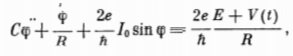

- underdamped limit $C \rightarrow 0$
- volage biasing scheme is equivalent to curernt-biasing with R as a shunt
- note the difference between $I-V_b$ and $I-V$ curves 

$$<I_s> = I_0 \Im \left( \frac{I_{1-2i\beta e V_B/ \hbar R_B}(\beta E_J)}{I_{-2i\beta e V_B/ \hbar R_B}(\beta E_J)} \right)$$

In [12]:
fig, ax = plt.subplots()

Vs = np.linspace(0, 1e-3, 501)

R_list = [1e3, 10e3, 50e3]

for R in R_list:
    Is = I_IZ( Vs, EJ = .5, R = R, T = .05)

# ax.plot(  Vs/1e-3, Is/1e-9, '--', label = r'$I-V_b$')
    ax.plot( (Vs - Is*R) /1e-3, Is/1e-9, label = f'{R/1e3} kOhm' )
ax.set_xlabel(r'$V, mV$')
ax.set_ylabel(r'$I, nA$')


# ax.set_xlim(0, .1e-3)
# ax.set_xscale ('log')
ax.legend()


FigureCanvasNbAgg()

In [39]:
fig, ax = plt.subplots()

Vs = np.logspace(-5, -2, 501)

# R_list = [1e3, 20e3, 12e3]

R_list = [ 1e3]

for R in R_list:
    Is = I_IZ( Vs, EJ = .5, R = R, T = .05)
    
    ind = np.where (np.diff (Is ) / np.diff (Vs - Is*R) >0)

#     print(ind)
    Is, Vs = Is[:-1][ind], Vs[:-1][ind]

# ax.plot(  Vs/1e-3, Is/1e-9, '--', label = r'$I-V_b$')
    ax.plot( Is/1e-9,(Vs - Is*R) /1e-3,  label = f'{R/1e3} kOhm' )
    
    
    
    V_fit = lambda x, A,B  : A*np.sinh(x*B )
    popt1 = ( 1e-3 , 1e-3)
    popt, pcov = curve_fit(V_fit, Is/1e-12 ,(Vs - Is*R)/1e-6, p0 = popt1 )

    Vf = V_fit(Is/1e-12, *popt)*1e-6
    ax.plot(Is/1e-9, Vf/1e-3,'--' )
    
ax.set_ylabel(r'$V, mV$')
ax.set_xlabel(r'$I, nA$')


# ax.set_xlim(0, .1e-3)
# ax.set_xscale ('log')
ax.legend()


D:\anaconda\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """Entry point for launching an IPython kernel.


FigureCanvasNbAgg()

In [75]:
fig, ax = plt.subplots()

Ic = 35e-9

Vs = np.logspace(-5, -2, 501)
# Vs = np.linspace(0, 1e-2, 501)

R = 1e3

T_list = np.linspace(0.05, 0.5, 21)
As = []
Bs = []


Ims =[]
for T in T_list:

    Is = I_IZ( Vs, EJ = 1.25, R = R, T = T)
    
    ind = np.where (np.diff (Is ) / np.diff (Vs - Is*R) >0)

#     print(ind)
    Is, Vs = Is[:-1][ind], Vs[:-1][ind]


    Ims.append(Is[np.argmax(Vs)])
    
    ax.plot( Is/1e-9,(Vs - Is*R) /1e-3,  label = f'{R/1e3} kOhm' )

    V_fit = lambda x, A,B  : A*np.sinh(x*B )
    popt1 = ( 1e-3 , 1e-3)
    popt, pcov = curve_fit(V_fit, Is/1e-12 ,(Vs - Is*R)/1e-6, p0 = popt1 )

    Vf = V_fit(Is/1e-12, *popt)*1e-6
    ax.plot(Is/1e-9, Vf/1e-3,'--' )
    
    A, B = popt[0], popt[1]
    
    As.append(A)
    Bs.append(B)

 

    # ax.plot(  Vs/1e-3, (Is - Vs/R)/1e-9, label = r'$I_s - V$')


#     ax.set_xlabel(r'$V, mV$')
#     ax.set_ylabel(r'$I, nA$')

    print(popt)

# ax.legend()

# Bs = np.array(Bs)
# ax.plot(T_list, As)

# # ax.set_xscale('log')
# # ax.set_yscale('log')
# ax2 = ax.twinx()
# ax2.plot(T_list, Bs/T_list, c = 'C1')

# ax2.set_yscale('log')

# fig, ax = plt.subplots()
# ax.plot(T_list, Ims, 'o-')

D:\anaconda\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """Entry point for launching an IPython kernel.


FigureCanvasNbAgg()

[-4.00052445e-18  1.00000000e-03]
[1.65752614e-13 7.55186412e-04]
[1.68236302e-11 6.79468426e-04]
[6.47292942e-09 5.53981127e-04]
[1.25960884e-07 4.98414403e-04]
[1.51275530e-06 4.49594141e-04]
[1.19719013e-05 4.07486618e-04]
[6.70457265e-05 3.71427055e-04]
[0.00028339 0.00034057]
[0.00095343 0.00031413]
[0.00266359 0.00029142]
[0.00638713 0.0002719 ]
[0.01349824 0.00025511]
[0.02569004 0.00024066]
[0.04483147 0.00022821]
[0.07282247 0.00021745]
[0.11148186 0.0002081 ]
[0.16247884 0.00019994]
[2.27293248e-01 1.92770838e-04]
[3.07199671e-01 1.86443894e-04]
[4.03256137e-01 1.80831324e-04]


In [76]:
fig, ax = plt.subplots()

ax.plot(T_list, Ims, 'o-')

D:\anaconda\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """Entry point for launching an IPython kernel.


FigureCanvasNbAgg()

In [69]:
fig, ax = plt.subplots()

Bs = np.array(Bs)
ax.plot(T_list, As, 'o-')

# ax.set_xscale('log')
# ax.set_yscale('log')
ax2 = ax.twinx()
ax2.plot(T_list, Bs/T_list, 'o-', c = 'C1')

# ax2.set_yscale('log')



D:\anaconda\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """Entry point for launching an IPython kernel.


FigureCanvasNbAgg()

In [3]:

R_env_list = np.logspace(2, 5, 51)



EJ = 0.15
T =  0.05

fig, ax = plt.subplots()
ax2 = ax.twinx()

for EJ in [0.15, 0.25, 0.35]:

    R0s  = []
    Isws = []

    for R_env in R_env_list:

        R0, Isw = find_R0_Isw( EJ, R_env , T, VERBOSE = False)
        R0s.append(R0)
        Isws.append(Isw)


    ax.plot(R_env_list, R0s, label = f'EJ = {EJ} K')




    ax2.plot(R_env_list, Isws, '--')
    
ax.legend()    

ax.set_xscale ('log')
ax.set_yscale ('log')

ax2.set_yscale ('log')


FigureCanvasNbAgg()

In [5]:

EJ_list = np.logspace(-2, 1, 51)



# R_env = 0.15
T =  0.05

fig, ax = plt.subplots()
ax2 = ax.twinx()

for R_env in [1e3, 1e5]:

    R0s  = []
    Isws = []

    for EJ in EJ_list:

        R0, Isw = find_R0_Isw( EJ, R_env , T, VERBOSE = False)
        R0s.append(R0)
        Isws.append(Isw)


    ax.plot(EJ_list, R0s, label = f'Renv = {R_env/1e3} kOhm')
    
    Ics = EJ_list/(Φ0/2/pi/kB)
    ax2.plot(EJ_list, Ics, '--')


#     ax2 = ax.twinx()
    Isws = np.array(Isws)
    ax2.plot(EJ_list, Isws/EJ_list, '--')
    
ax.legend()    

ax.set_xscale ('log')
ax.set_yscale ('log')

ax2.set_yscale ('log')


FigureCanvasNbAgg()

## 3. Phase diffusion as Fokker-Plank process -2
[Ambegaokar-Halperin PRL 22 25 1969](https://journals.aps.org/prl/pdf/10.1103/PhysRevLett.22.1364 )



- The same Fokker-Planck eq with non-zero $C$, overdamped limit $\eta = 1/RC \gg 1$
- Attempt frequency is $\omega_J^2 / 2 \pi \eta =  \omega_J / \beta_C$
- Derived for I-biased regime
- Note the difference between the total current through R||JJ and pure supercurrent

In [11]:
fig, ax = plt.subplots()

Ic = 35e-9

Is = np.linspace(0, 1.5*Ic, 501)

R = 1

T_list = np.linspace(0.05, 0.5, 11)
As = []
Bs = []


Ims =[]
for T in T_list:

    Vs = V_AH_star( Is, EJ =0.51, Rn = R,  T = T)

    ind = np.where (np.diff (Vs ) >0)

    Is, Vs = Is[:-1][ind][:-10], Vs[:-1][ind][:-10]

    Ims.append(Is[np.argmax(Vs)])
    
    ax.plot(   Is/1e-9, Vs/1e-3, label = r'$I_b - V$')


    V_fit = lambda x, A,B  : A*np.sinh(x*B )
    popt1 = ( 1e-3 , 1e-3)
    popt, pcov = curve_fit(V_fit, Is/1e-12 ,Vs/1e-6, p0 = popt1 )

    Vf = V_fit(Is/1e-12, *popt)*1e-6
    
    A, B = popt[0], popt[1]
    
    As.append(A)
    Bs.append(B)

    ax.plot(Is/1e-9, Vf/1e-3,'--' )


    # ax.plot(  Vs/1e-3, (Is - Vs/R)/1e-9, label = r'$I_s - V$')


#     ax.set_xlabel(r'$V, mV$')
#     ax.set_ylabel(r'$I, nA$')

    print(popt)

# ax.legend()

# Bs = np.array(Bs)
# ax.plot(T_list, As)

# # ax.set_xscale('log')
# # ax.set_yscale('log')
# ax2 = ax.twinx()
# ax2.plot(T_list, Bs/T_list, c = 'C1')

# ax2.set_yscale('log')

# fig, ax = plt.subplots()
# ax.plot(T_list, Ims, 'o-')

FigureCanvasNbAgg()

e:\OneDrive - Rutgers University\files_GitHub\JJ_arrays\JJformulas.py:140: RuntimeWarning: invalid value encountered in sqrt
  i_ = (1 - i**2)**0.5
e:\OneDrive - Rutgers University\files_GitHub\JJ_arrays\JJformulas.py:142: RuntimeWarning: invalid value encountered in arcsin
  return 2*Ic0*Rn* i_ * np.exp( -Γ*( i_ + i*np.arcsin(i) ))*np.sinh(np.pi/2*Γ*i)
D:\anaconda\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in greater


[6.97901002e-07 5.08093587e-04]
[3.69897391e-05 3.30240945e-04]
[0.00019906 0.00025733]
[0.00056441 0.00021161]
[0.00120295 0.00017683]
[0.00217945 0.00014796]
[0.00357014 0.00012286]
[0.00551522 0.00010019]
[8.35680367e-03 7.88027008e-05]
[1.31787328e-02 5.71626939e-05]
[2.67387938e-02 3.12563135e-05]


## 4. Phase diffusion as activation process 
Kautz Martinis

### 4a. Thermally activated PD

# Coulomb at P(E)

## $E_J$ renormalization

In the limit $E_J \ll E_C$ and high-resistive environment a probability of CP tunneling is quadratic in $E_J$ and effective $E_J$ can be calculated ([Mesoscopic Josephson Effect Superlatt. Microstruct. 25, 915 (1999)](https://www.physik.uni-augsburg.de/theo1/ingold/publikationen_coll/grabe99/grabe99.pdf) )


In [13]:
Renv_list = np.logspace(2, 6, 101)

RN = 10e3


Cj_list = [1e-15, 1.5e-15, 2e-15]
fig, ax1 = plt.subplots()

for Cj in Cj_list:
    EJs = EJ_star (EJ = EJ_AB(RN), R = Renv_list, T = .03, C = Cj)

    ax1.plot( Renv_list , EJs, label = r'C = {:1.2f} fF'.format(Cj/1e-15 ))

# ax1.plot( Renv_list , EJ_AB(RN), '--k', alpha = 0.5)
ax1.axhline(EJ_AB(RN), 0 , 1, ls = '--', color = 'k', alpha = 0.5)


ax1.legend()

ax1.set_xscale('log')
ax1.set_yscale('log')

ax1.set_xlabel(r'$R_{env}, K$')
ax1.set_ylabel(r'$E_J^*, K$')

FigureCanvasNbAgg()

Text(0, 0.5, '$E_J^*, K$')

### T-dependence

In [14]:
Renv_list = np.logspace(2, 6, 101)

RN = 10e3

Cj = 1.5e-15

Tb_list = [0.05, 0.10, .15]
fig, ax1 = plt.subplots()

for Tb in Tb_list:
    EJs = EJ_star (EJ = EJ_AB(RN), R = Renv_list, T = Tb, C = Cj)

    ax1.plot( Renv_list , EJs, label = r'T = {:3.0f} mK'.format(Tb/1e-3 ))

# ax1.plot( Renv_list , EJ_AB(RN), '--k', alpha = 0.5)
ax1.axhline(EJ_AB(RN), 0 , 1, ls = '--', color = 'k', alpha = 0.5)


ax1.legend()

ax1.set_xscale('log')
ax1.set_yscale('log')

ax1.set_xlabel(r'$R_{env}, K$')
ax1.set_ylabel(r'$E_J^*, K$')

FigureCanvasNbAgg()

Text(0, 0.5, '$E_J^*, K$')

## $R_0$ as a result of thermal diffusion + $E_J$ renormalization

In [24]:
R_list = np.logspace(2, 5.5, 51)

Cj = 1.75e-15
Tb = 0.035



fig, ax1 = plt.subplots()

R0s = []

for R in R_list:
    EJs = EJ_star (EJ = EJ_AB(R), R = 1e3, T = Tb, C = Cj)
    R0, _ = find_R0_Isw( EJs ,R_env = 1e3, T = Tb)
    R0s.append(R0)

ax1.plot( EJ_AB(R_list) , R0s, label = r'C = {:1.2f} fF'.format(Cj/1e-15))




ax1.legend()

# ax1.set_xscale('log')
ax1.set_yscale('log')

ax1.set_xlabel(r'$E_J, K$')
ax1.set_ylabel(r'$R_0, k \Omega$')

FigureCanvasNbAgg()

Text(0, 0.5, '$R_0, k \\Omega$')

### T-dependence

In [16]:
RN = 10e3
R_env = 100e3

Cj = 2e-15
Tb_list =  np.linspace(0.05, .25, 51)

# EJs = EJ_star (EJ = EJ_AB(RN), R = R_env, T = Tb, C = Cj)

fig, ax1 = plt.subplots()

R0s = []

for Tb in Tb_list:
    R0 = find_R0( RN, R_env = R_env , T = Tb, C = Cj)
    R0s.append(R0)

ax1.plot( Tb_list , R0s, label = r'C = {:1.2f} fF'.format(Cj/1e-15))




ax1.legend()

# ax1.set_xscale('log')
ax1.set_yscale('log')

ax1.set_xlabel(r'$T, K$')
ax1.set_ylabel(r'$R, k \Omega$')

FigureCanvasNbAgg()

Text(0, 0.5, '$R, k \\Omega$')

In [17]:
fig, ax = plt.subplots()
T = np.linspace(0.05, 4.05, 101)

# ax.plot( T , Rj(1e3, T))
ax.plot( T , 1 / ( 1e-9 +  1e-6*np.exp(  -2/T )) )  
ax.set_yscale('log')

FigureCanvasNbAgg()

In [18]:
np.exp(-100)

3.720075976020836e-44

# Kautz-Martinis


In [6]:
fig, ax = plt.subplots()
Tb = np.linspace(0.05, 4.05, 101)

Nps, Nms = Njump(i = 0.5, Q = 50, EJ = 1, T = Tb)

ax.plot(Tb, Nps)
ax.plot(Tb, Nms)

FigureCanvasNbAgg()

In [7]:
fig, ax = plt.subplots()
i = np.linspace(0.0, 1/3, 101)

Nps, Nms = Njump(i = i, Q = 5, EJ = 1, T = 0.2)

ax.plot(i, Nps)
ax.plot(i, Nms)

FigureCanvasNbAgg()

e:\OneDrive - Rutgers University\files_GitHub\JJ_arrays\JJformulas.py:176: RuntimeWarning: invalid value encountered in log
  Np = 1 + 2*Q/np.pi**2*( Ed - 1 ) + i*Q**2/2/np.pi*np.log( ( Ed - im )/(1 - im) )


In [8]:
fig, ax = plt.subplots()
Tb = np.linspace(0.05, 4.05, 101)

τp, τm = τ(i = 0.1, EJ = 1, Ec = 0.5, T = Tb)

ax.plot(1/Tb, τp)
ax.plot(1/Tb, τm)

ax.set_yscale('log')

FigureCanvasNbAgg()

In [9]:
fig, ax = plt.subplots()
i = np.linspace(0.0, 1, 101)

ΔUp, ΔUm = ΔU(i, EJ)

ax.plot(i, ΔUp)
ax.plot(i, ΔUm)

FigureCanvasNbAgg()

In [12]:
Q = 10

fig, ax = plt.subplots()

for EJ in [1, .5 , .1]:
    i = np.linspace(-1/Q, 1/Q, 101)

    Vs = V_KM(i, EJ = EJ, Ec = 0.9, Q = 2*Q, T = 0.75)

    ax.plot(i, Vs)


FigureCanvasNbAgg()

e:\OneDrive - Rutgers University\files_GitHub\JJ_arrays\JJformulas.py:176: RuntimeWarning: invalid value encountered in log
  Np = 1 + 2*Q/np.pi**2*( Ed - 1 ) + i*Q**2/2/np.pi*np.log( ( Ed - im )/(1 - im) )
e:\OneDrive - Rutgers University\files_GitHub\JJ_arrays\JJformulas.py:177: RuntimeWarning: invalid value encountered in log
  Nm = 1 + 2*Q/np.pi**2*( Ed - 1 ) - i*Q**2/2/np.pi*np.log( ( Ed + im )/(1 + im) )


# Quantum charge diffusion (Zazunov 2008)

In [3]:
kB = k
γ = 0.57721566
RQ = h/4/e**2
Φ0 = h/2/e  
Δ = 2.1*kB


<IPython.core.display.Javascript object>


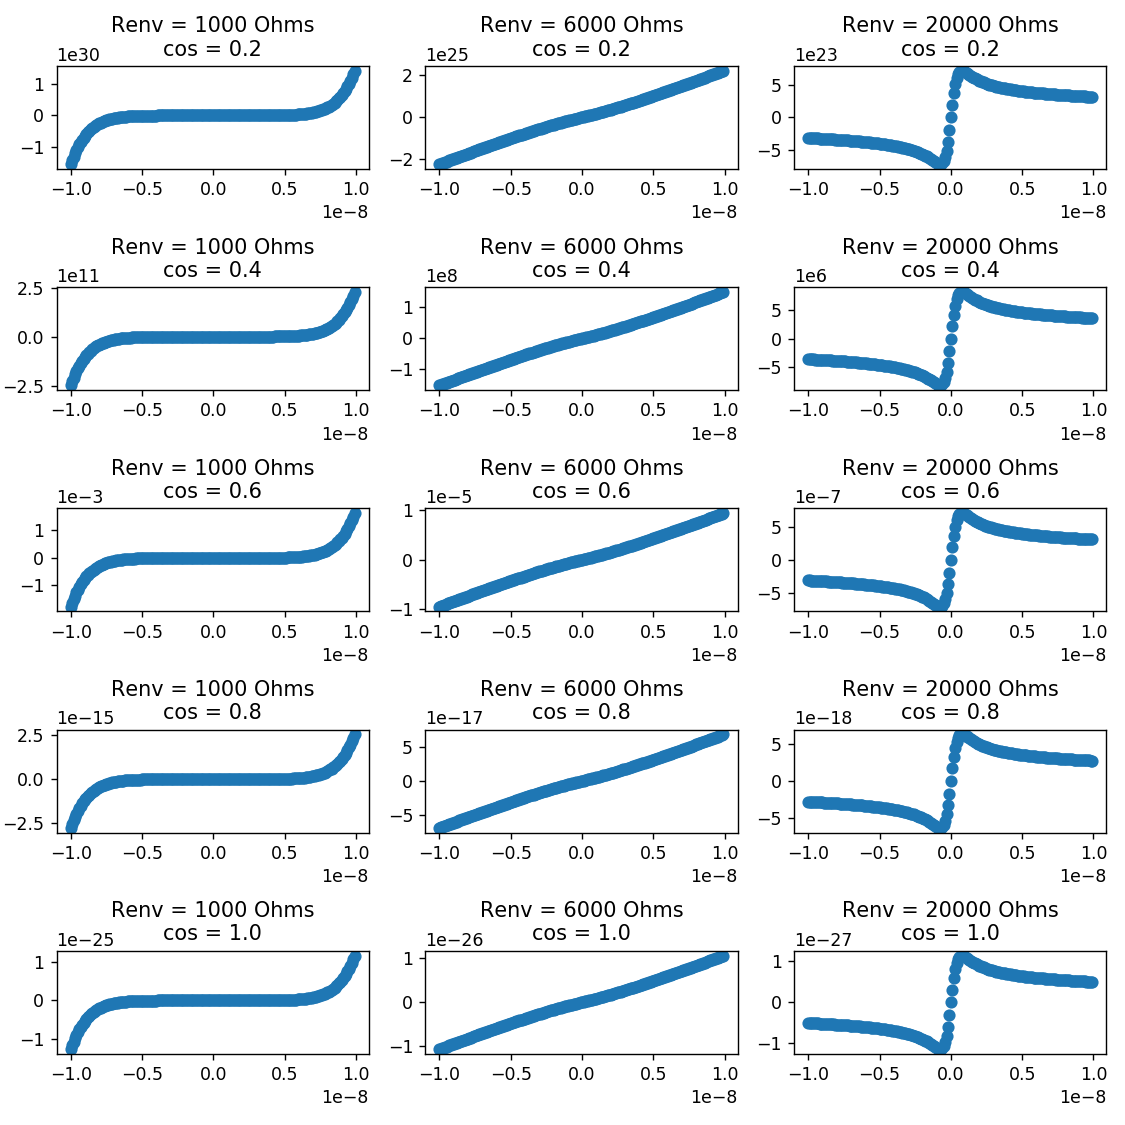

In [4]:
#%matplotlib notebook

#Ej = 2.81
#Ec = 0.002
Ej = 1.77
Ec = 0.0049
T = 0.05



fig = plt.figure(figsize = (9,9))
gs = GridSpec.GridSpec(5, 3)



Renvs = [1e3,6e3,20e3]
cosines = np.arange(0.2,1.1,0.2)
a = 0

for j in range(5):    
    
    for i in range(3):
        
        I = np.arange(-1e-8,1e-8,1e-10)
        V = []
        
        ax = fig.add_subplot(gs[a])
        
        for Ibias in I:
        
            V = np.append(V,V_NNA_smallg_Ejfit(Renvs[i],T,Ibias,Ej,Ec,cosines[j]))    
        
        ax.plot( I, V , 'o')#, label = 'test')
        ax.set_title('Renv = ' + str(round(Renvs[i])) + ' Ohms' + '\n' + 'cos = ' + str(round(cosines[j],2)))
        ax.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
        #ax.legend()
        
        a += 1
        
    
plt.tight_layout()

In [33]:
plt.close('all')